In [11]:
import numpy as np
import pandas
import urllib2
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats
import math
import matplotlib.gridspec as gridspec

In [12]:
chrs_length = [249250621,243199373,198022430,191154276,180915260,171115067,159138663,146364022,141213431,135534747,135006516,133851895,115169878,107349540,102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566]
res = 10000

In [13]:
def compute_jaccard_index(set_1, set_2, offset):
    if offset == 0:
        n = len(np.intersect1d(set_1,set_2))
    else:
        set_1_offset=np.copy(set_1)
        for i in range(0,offset):
            set_1_offset = np.union1d(np.union1d(set_1_offset,set_1_offset - 1),set_1_offset + 1)
        n = len(np.intersect1d(set_1_offset,set_2))
    return n / float(len(np.union1d(set_1,set_2)))

In [14]:
def TADtoCluster (tads, chrbinlen, maxdist):
    tmat = np.zeros((chrbinlen,chrbinlen))
    ftads = tads[(tads[:,1]-tads[:,0]).argsort()[::-1],:].astype(int)
    a = []
    for i in range(0,ftads.shape[0]):
        tmat[ftads[i,0]:ftads[i,1],ftads[i,0]:ftads[i,1]] = i
    for offset in range(0,min(maxdist,chrbinlen-1)):
        ta= [row[rown+offset] for rown,row in enumerate(tmat) if rown+offset < len(row)]
        a+=ta
    return np.asarray(a)

In [15]:
def ResTo10_tad (tads, res):
    diff = res / 10.0
    tads = tads * diff
    tads[:,0] = tads[:,0].astype(int)
    tads[:,1] = np.ceil(tads[:,1])
    return tads


def compute_jaccard_index_diffres(set_1, set_2, res1, res2):
    difflist = []
    for i in set_1:
        difflist.append(np.min(np.absolute(set_2*res2 - i*res1)))
    n = sum(np.array(difflist)<=max(res1,res2))     
    u = len(set_1) + len(set_2) - n 
    return n / float(u)

In [16]:
def readTADtree (turl):
    TADtreeUrlr = urllib2.urlopen(urllib2.Request(turl)).read()
    TADtreeUrlstringr=re.findall("N\d+",TADtreeUrlr)
    flist = [int(x.split('N')[1]) for x in TADtreeUrlstringr]       
    TADtreer = pandas.read_table(urllib2.urlopen(turl+'/N'+str(max(flist))+'.txt'),sep='\t',header=0)
    TADtreeTADr = TADtreer[['start','end']].values-1
    TADtreeTADrb = np.unique(TADtreeTADr.flatten())
    return (TADtreeTADr, TADtreeTADrb)
    

In [20]:
OnTAD_jarrep = []
OnTAD_randrep = []
Arrow_jarrep = []
Arrow_randrep = []
TADtree_jarrep = []
TADtree_randrep = []
rGMAP_jarrep = []
rGMAP_randrep = []
##Arrowhead doesn't have result on replicate chr22. TADtree doesn't have result on primary chr1 and replicate chr2
for chrnum in range(3,22):
    OnTAD_rawrep1 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878_primary/10kb/OnTAD_KRnorm_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_rawrep1a = OnTAD_rawrep1.loc[(OnTAD_rawrep1[2]>0),:].values[:,0:2]-1
    OnTAD_rawrep1b = np.unique(OnTAD_rawrep1a.flatten())
    OnTAD_rep1t = TADtoCluster(OnTAD_rawrep1a, chrs_length[chrnum-1]/res, 200)
    OnTAD_rawrep2 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878_replicate/10kb/OnTAD_KRnorm_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
    OnTAD_rawrep2a = OnTAD_rawrep2.loc[(OnTAD_rawrep2[2]>0),:].values[:,0:2]-1
    OnTAD_rawrep2b = np.unique(OnTAD_rawrep2a.flatten())
    OnTAD_rep2t = TADtoCluster(OnTAD_rawrep2a, chrs_length[chrnum-1]/res, 200)
    OnTAD_jarrep.append(compute_jaccard_index(OnTAD_rawrep1b,OnTAD_rawrep2b,0))
    OnTAD_randrep.append(adjusted_rand_score(OnTAD_rep1t, OnTAD_rep2t))
    
    Arrowheadrep1 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878_pri.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
    Arrowrep1 = Arrowheadrep1.loc[:,1:2].values/res
    Arrowrep1b=np.unique(Arrowrep1.flatten())
    Arrowrep1t = TADtoCluster(Arrowrep1, chrs_length[chrnum-1]/res, 200)
    Arrowheadrep2 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878_rep.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
    Arrowrep2 = Arrowheadrep2.loc[:,1:2].values/res
    Arrowrep2b=np.unique(Arrowrep2.flatten())
    Arrowrep2t = TADtoCluster(Arrowrep2, chrs_length[chrnum-1]/res, 200)
    Arrow_jarrep.append(compute_jaccard_index(Arrowrep1b,Arrowrep2b,0))
    Arrow_randrep.append(adjusted_rand_score(Arrowrep1t, Arrowrep2t))
    
    TADtreeUrlrep1 = urllib2.urlopen(urllib2.Request('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2_KRnorm/Gm12878_primary/chr'+str(chrnum))).read()
    TADtreeUrlstringrep1=re.findall("N\d+",TADtreeUrlrep1)
    flist = [int(x.split('N')[1]) for x in TADtreeUrlstringrep1]       
    TADtreerep1 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2_KRnorm/Gm12878_primary/chr'+str(chrnum)+'/N'+str(max(flist))+'.txt'),sep='\t',header=0)
    TADtreeTADrep1 = TADtreerep1[['start','end']].values-1
    TADtreeTADrep1b = np.unique(TADtreeTADrep1.flatten())
    TADtreeTADrep1t = TADtoCluster(TADtreeTADrep1, chrs_length[chrnum-1]/res, 200)
    TADtreeUrlrep2 = urllib2.urlopen(urllib2.Request('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2_KRnorm/Gm12878_replicate/chr'+str(chrnum))).read()
    TADtreeUrlstringrep2=re.findall("N\d+",TADtreeUrlrep2)
    flist = [int(x.split('N')[1]) for x in TADtreeUrlstringrep2]       
    TADtreerep2 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2_KRnorm/Gm12878_replicate/chr'+str(chrnum)+'/N'+str(max(flist))+'.txt'),sep='\t',header=0)
    TADtreeTADrep2 = TADtreerep2[['start','end']].values-1
    TADtreeTADrep2b = np.unique(TADtreeTADrep2.flatten())
    TADtreeTADrep2t = TADtoCluster(TADtreeTADrep2, chrs_length[chrnum-1]/res, 200)
    TADtree_jarrep.append(compute_jaccard_index(TADtreeTADrep1b,TADtreeTADrep2b,0))
    TADtree_randrep.append(adjusted_rand_score(TADtreeTADrep1t, TADtreeTADrep2t))
    
    rGrep1 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_primary_10000_chr'+str(chrnum)+'.rGMAPTAD'),sep='\t',header=None)
    rGMAPrep1=rGrep1.loc[:,0:1].values/res
    rGMAPrep1b=np.unique(rGMAPrep1.flatten())
    rGMAPrep1t = TADtoCluster(rGMAPrep1, chrs_length[chrnum-1]/res, 200)
    rGrep2 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_replicate_10000_chr'+str(chrnum)+'.rGMAPTAD'),sep='\t',header=None)
    rGMAPrep2=rGrep2.loc[:,0:1].values/res
    rGMAPrep2b=np.unique(rGMAPrep2.flatten())
    rGMAPrep2t = TADtoCluster(rGMAPrep2, chrs_length[chrnum-1]/res, 200)
    rGMAP_jarrep.append(compute_jaccard_index(rGMAPrep1b,rGMAPrep2b,0))
    rGMAP_randrep.append(adjusted_rand_score(rGMAPrep1t, rGMAPrep2t))
    print '####Done with chr'+str(chrnum)+'####'

####Done with chr3####
####Done with chr4####
####Done with chr5####
####Done with chr6####
####Done with chr7####
####Done with chr8####
####Done with chr9####
####Done with chr10####
####Done with chr11####
####Done with chr12####
####Done with chr13####
####Done with chr14####
####Done with chr15####
####Done with chr16####
####Done with chr17####
####Done with chr18####
####Done with chr19####
####Done with chr20####
####Done with chr21####


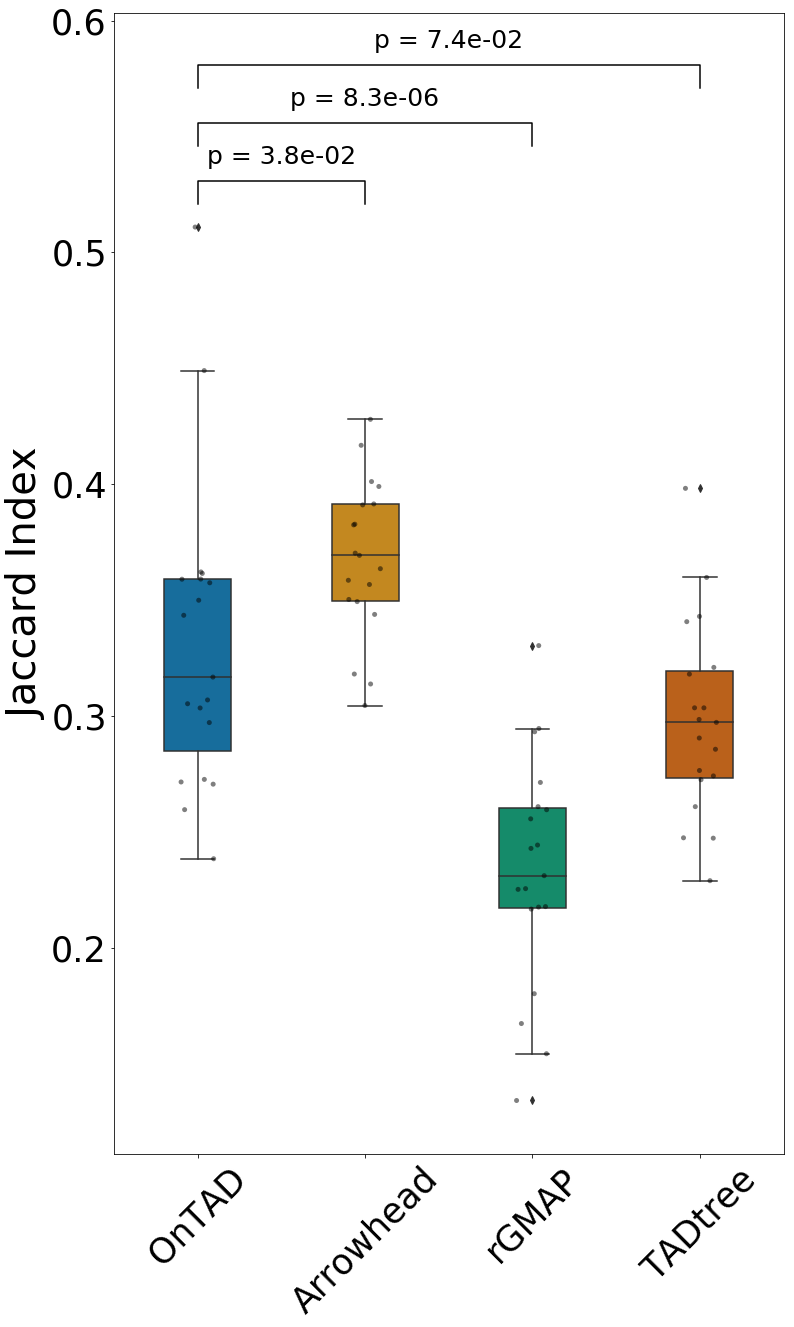

In [96]:
jartable = pandas.DataFrame({'OnTAD':OnTAD_jarrep, 'Arrowhead':Arrow_jarrep, 'rGMAP': rGMAP_jarrep,'TADtree':TADtree_jarrep})

plt.figure(1,figsize=(12,21))
sns.boxplot(data=jartable, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=jartable,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = jartable['OnTAD'].max() + 0.01, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jarrep, Arrow_jarrep)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':25})

x1, x2 = 0, 2   # columns 
plt.plot([x1, x1, x2, x2], [y+2.5*h, y+3.5*h, y+3.5*h, y+2.5*h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+4*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jarrep, rGMAP_jarrep)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':25})

x1, x2 = 0, 3   # columns 
plt.plot([x1, x1, x2, x2], [y+5*h, y+6*h, y+6*h, y+5*h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+6.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jarrep, TADtree_jarrep)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':25})

plt.yticks(color='k',size=35)
plt.xticks(color='k',size=35)
plt.xticks(rotation=45)
plt.ylabel('Jaccard Index', {'color': 'k', 'fontsize': 40})
plt.savefig("/Users/linan/Desktop/rep_betweenrep.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

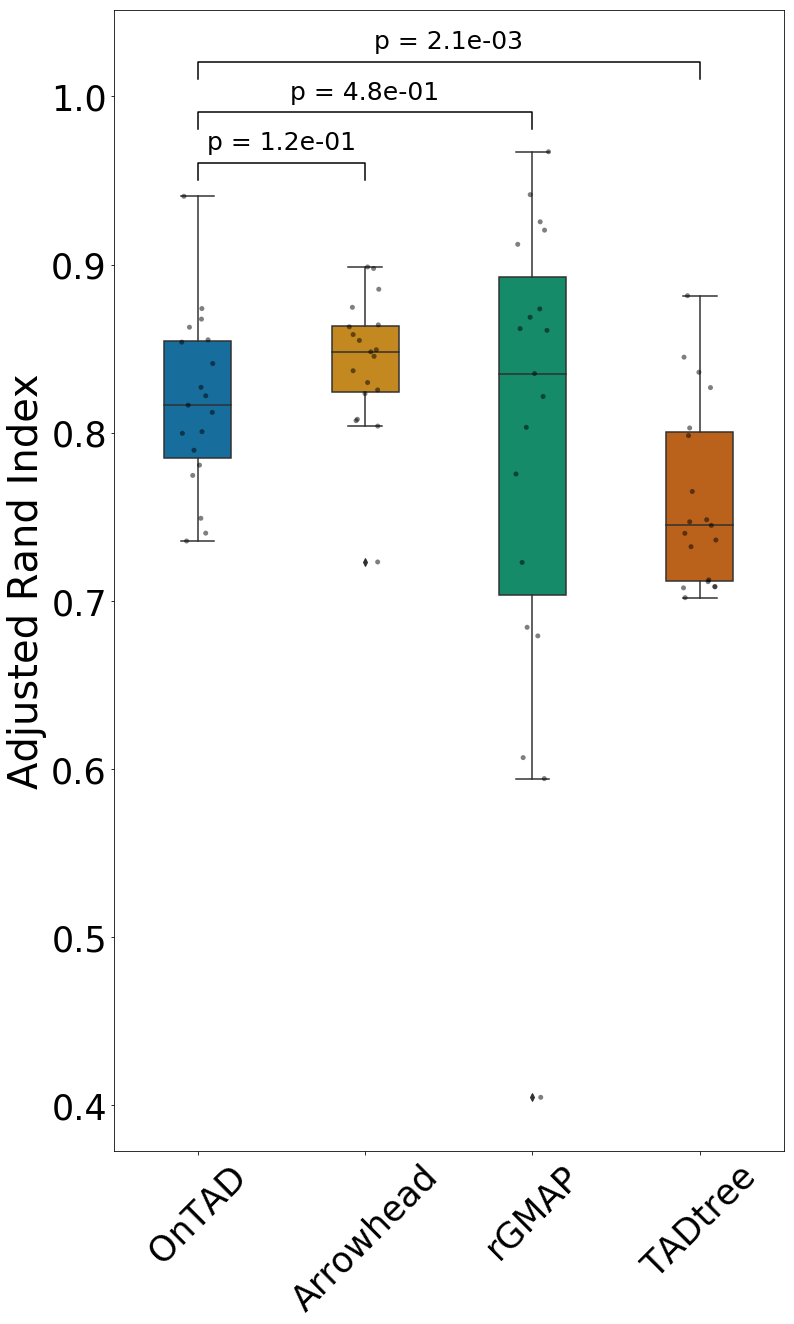

In [97]:
plt.figure(2,figsize=(12,21))
randtable = pandas.DataFrame({'OnTAD':OnTAD_randrep, 'Arrowhead':Arrow_randrep, 'rGMAP': rGMAP_randrep,'TADtree':TADtree_randrep})
sns.boxplot(data=randtable, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=randtable,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = randtable['OnTAD'].max() + 0.01, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randrep, Arrow_randrep)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':25})

x1, x2 = 0, 2   # columns 
plt.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randrep, rGMAP_randrep)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':25})

x1, x2 = 0, 3   # columns 
plt.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randrep, TADtree_randrep)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':25})

plt.yticks(color='k',size=35)
plt.xticks(color='k',size=35)
#sns.despine(trim=True, left=True)
plt.xticks(rotation=45)
plt.ylabel('Adjusted Rand Index', {'color': 'k', 'fontsize': 40})
plt.savefig("/Users/linan/Desktop/rand_betweenrep.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

In [75]:
OnTAD_jar5vs10 = []
OnTAD_rand5vs10 = []
Arrow_jar5vs10 = []
Arrow_rand5vs10 = []
rGMAP_jar5vs10 = []
rGMAP_rand5vs10 = []
OnTAD_jar25vs10 = []
OnTAD_rand25vs10 = []
Arrow_jar25vs10 = []
Arrow_rand25vs10 = []
rGMAP_jar25vs10 = []
rGMAP_rand25vs10 = []
##rGMAP doesn't have result on 5kb chr1,2&9. TADtree cannot run on 5kb
for chrnum in range(3,23):
    if chrnum != 9:
        OnTAD_raw10 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_KRnorm_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_raw10a = OnTAD_raw10.loc[(OnTAD_raw10[2]>0),:].values[:,0:2]-1
        OnTAD_raw10b = np.unique(OnTAD_raw10a.flatten())
        OnTAD10t = TADtoCluster(OnTAD_raw10a, chrs_length[chrnum-1]/res, 200)
        OnTAD_raw5 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/5kb/OnTAD_KRnorm_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_raw5a = OnTAD_raw5.loc[(OnTAD_raw5[2]>0),:].values[:,0:2]-1
        OnTAD_raw5b = np.unique(OnTAD_raw5a.flatten())
        OnTAD5t = TADtoCluster(ResTo10_tad(OnTAD_raw5a,5), chrs_length[chrnum-1]/res, 200)
        OnTAD_raw25 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/25kb/OnTAD_KRnorm_pen0.1_max80_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_raw25a = OnTAD_raw25.loc[(OnTAD_raw25[2]>0),:].values[:,0:2]-1
        OnTAD_raw25b = np.unique(OnTAD_raw25a.flatten())
        OnTAD25t = TADtoCluster(ResTo10_tad(OnTAD_raw25a,25), chrs_length[chrnum-1]/res, 200)
        OnTAD_jar5vs10.append(compute_jaccard_index_diffres(OnTAD_raw5b,OnTAD_raw10b,5000,10000))
        OnTAD_jar25vs10.append(compute_jaccard_index_diffres(OnTAD_raw25b,OnTAD_raw10b,25000,10000))
        OnTAD_rand5vs10.append(adjusted_rand_score(OnTAD5t, OnTAD10t))
        OnTAD_rand25vs10.append(adjusted_rand_score(OnTAD25t, OnTAD10t))
        

        Arrowhead10 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
        Arrow10 = Arrowhead10.loc[:,1:2].values/10000
        Arrow10b=np.unique(Arrow10.flatten())
        Arrow10t = TADtoCluster(Arrow10, chrs_length[chrnum-1]/res, 200)
        Arrowhead5 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.combined.5kb.m3000.KR.chr'+str(chrnum)),sep='\t',header=None)
        Arrow5 = Arrowhead5.loc[:,1:2].values/5000
        Arrow5b=np.unique(Arrow5.flatten())
        Arrow5t = TADtoCluster(ResTo10_tad(Arrow5,5), chrs_length[chrnum-1]/res, 200)
        Arrowhead25 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.combined.25kb.m1000.KR.chr'+str(chrnum)),sep='\t',header=None)
        Arrow25 = Arrowhead25.loc[:,1:2].values/25000
        Arrow25b=np.unique(Arrow25.flatten())
        Arrow25t = TADtoCluster(ResTo10_tad(Arrow25,25), chrs_length[chrnum-1]/res, 200)
        Arrow_jar5vs10.append(compute_jaccard_index_diffres(Arrow5b,Arrow10b,5000,10000))
        Arrow_jar25vs10.append(compute_jaccard_index_diffres(Arrow25b,Arrow10b,25000,10000))
        Arrow_rand5vs10.append(adjusted_rand_score(Arrow5t, Arrow10t))
        Arrow_rand25vs10.append(adjusted_rand_score(Arrow25t, Arrow10t))

        rG10 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_combined_10000_chr'+str(chrnum)+'.rGMAPTAD'),sep='\t',header=None)
        rGMAP10=rG10.loc[:,0:1].values/10000
        rGMAP10b=np.unique(rGMAP10.flatten())
        rGMAP10t = TADtoCluster(rGMAP10, chrs_length[chrnum-1]/res, 200)
        rG5 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_combined_5000_chr'+str(chrnum)+'.rGMAPTAD'),sep='\t',header=None)
        rGMAP5=rG5.loc[:,0:1].values/5000
        rGMAP5b=np.unique(rGMAP5.flatten())
        rGMAP5t = TADtoCluster(ResTo10_tad(rGMAP5,5), chrs_length[chrnum-1]/res, 200)
        rG25 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_combined_25000_chr'+str(chrnum)+'.rGMAPTAD'),sep='\t',header=None)
        rGMAP25=rG25.loc[:,0:1].values/25000
        rGMAP25b=np.unique(rGMAP25.flatten())
        rGMAP25t = TADtoCluster(ResTo10_tad(rGMAP25,25), chrs_length[chrnum-1]/res, 200)
        rGMAP_jar5vs10.append(compute_jaccard_index_diffres(rGMAP5b,rGMAP10b,5000,10000))
        rGMAP_jar25vs10.append(compute_jaccard_index_diffres(rGMAP25b,rGMAP10b,25000,10000))
        rGMAP_rand5vs10.append(adjusted_rand_score(rGMAP5t, rGMAP10t))
        rGMAP_rand25vs10.append(adjusted_rand_score(rGMAP25t, rGMAP10t))
        print '####Done with chr'+str(chrnum)+'####'

####Done with chr3####
####Done with chr4####
####Done with chr5####
####Done with chr6####
####Done with chr7####
####Done with chr8####
####Done with chr10####
####Done with chr11####
####Done with chr12####
####Done with chr13####
####Done with chr14####
####Done with chr15####
####Done with chr16####
####Done with chr17####
####Done with chr18####
####Done with chr19####
####Done with chr20####
####Done with chr21####
####Done with chr22####


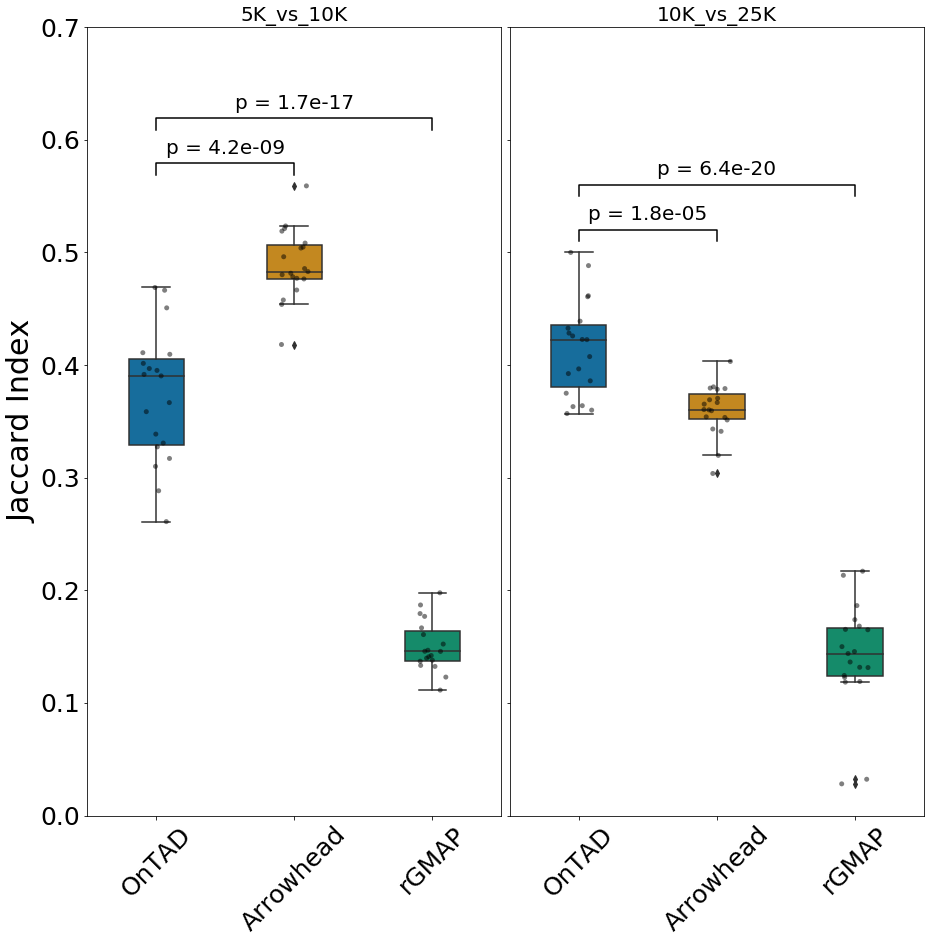

In [86]:
jartable5vs10 = pandas.DataFrame({'OnTAD':OnTAD_jar5vs10, 'Arrowhead':Arrow_jar5vs10, 'rGMAP': rGMAP_jar5vs10})
jartable25vs10 = pandas.DataFrame({'OnTAD':OnTAD_jar25vs10, 'Arrowhead':Arrow_jar25vs10, 'rGMAP': rGMAP_jar25vs10})
plt.figure(2,figsize=(15,15))

ax1 = plt.subplot(121)
sns.boxplot(data=jartable5vs10, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP'])
sns.stripplot(data=jartable5vs10,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = jartable5vs10.max()[0] + 0.01, 0.01, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jar5vs10, Arrow_jar5vs10)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':20})

x1, x2 = 0, 2   # columns 
ax1.plot([x1, x1, x2, x2], [y+4*h, y+5*h, y+5*h, y+4*h], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+5.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jar5vs10, rGMAP_jar5vs10)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':20})
#ax2 = fig.add_subplot(gs1[1], sharey=ax1)
ax1.set_ylim(0,0.7)
plt.yticks(color='k',size=25)
plt.xticks(color='k',size=25)
plt.xticks(rotation=45)
ax1.set_title('5K_vs_10K', fontdict={'fontsize':20})
plt.ylabel('Jaccard Index', {'color': 'k', 'fontsize': 30})
ax2 = plt.subplot(122, sharey=ax1)
sns.boxplot(data=jartable25vs10, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP'])
sns.stripplot(data=jartable25vs10,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = jartable25vs10.max()[1] + 0.01, 0.01, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jar25vs10, Arrow_jar25vs10)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':20})

x1, x2 = 0, 2   # columns 
ax2.plot([x1, x1, x2, x2], [y+4*h, y+5*h, y+5*h, y+4*h], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+5.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jar25vs10, rGMAP_jar25vs10)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':20})
plt.yticks(color='k',size=25)
plt.xticks(color='k',size=25)
plt.xticks(rotation=45)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_title('10K_vs_25K', fontdict={'fontsize':20})
plt.subplots_adjust(bottom=0.15, wspace=0.02)
ax2.set_ylim(0,0.7)
plt.savefig("/Users/linan/Desktop/rep_resolution.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

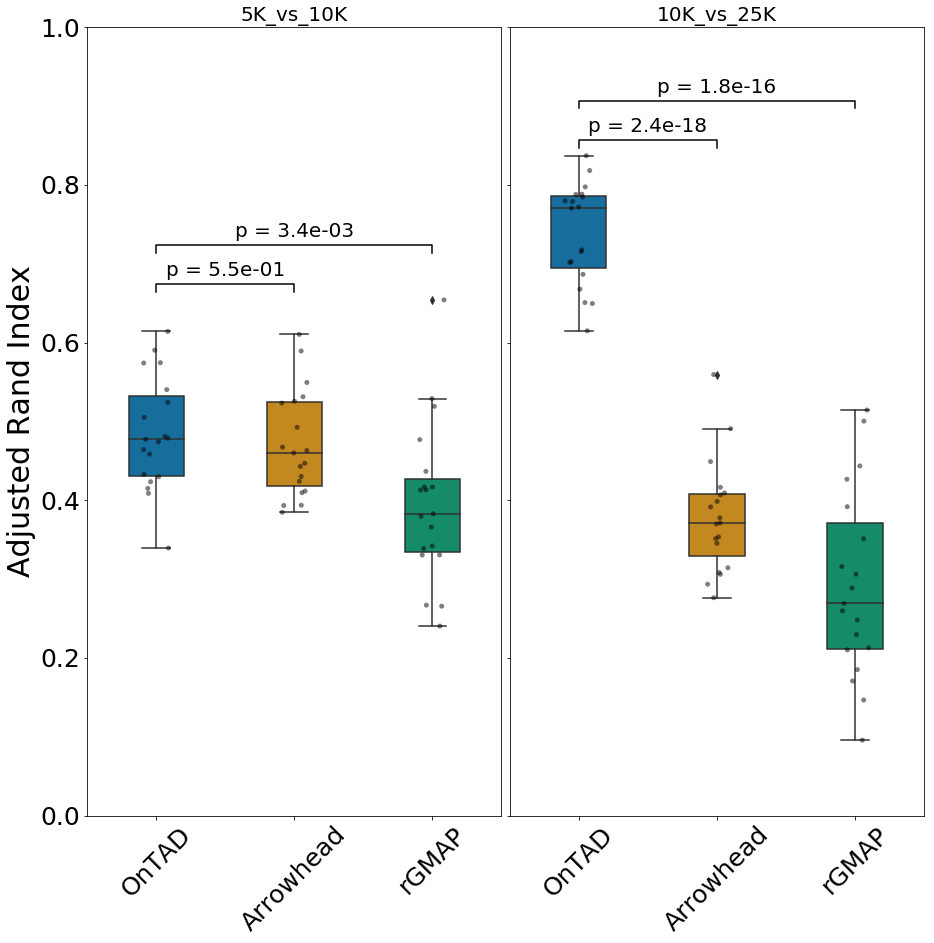

In [85]:
randtable5vs10 = pandas.DataFrame({'OnTAD':OnTAD_rand5vs10, 'Arrowhead':Arrow_rand5vs10, 'rGMAP': rGMAP_rand5vs10})
randtable25vs10 = pandas.DataFrame({'OnTAD':OnTAD_rand25vs10, 'Arrowhead':Arrow_rand25vs10, 'rGMAP': rGMAP_rand25vs10})
plt.figure(2,figsize=(15,15))
ax1 = plt.subplot(121)
sns.boxplot(data=randtable5vs10, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP'])
sns.stripplot(data=randtable5vs10, jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = randtable5vs10.max()[2] + 0.01, 0.01, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_rand5vs10, Arrow_rand5vs10)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':20})

x1, x2 = 0, 2   # columns 
ax1.plot([x1, x1, x2, x2], [y+5*h, y+6*h, y+6*h, y+5*h], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+6.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_rand5vs10, rGMAP_rand5vs10)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':20})
#ax2 = fig.add_subplot(gs1[1], sharey=ax1)
plt.yticks(color='k',size=25)
plt.xticks(color='k',size=25)
plt.xticks(rotation=45)
plt.ylim(0.2,1)
ax1.set_title('5K_vs_10K', fontdict={'fontsize':20})
plt.ylabel('Adjusted Rand Index', {'color': 'k', 'fontsize': 30})

ax2 = plt.subplot(122, sharey=ax1)
sns.boxplot(data=randtable25vs10, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP'])
sns.stripplot(data=randtable25vs10,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = randtable25vs10.max()[1] + 0.01, 0.01, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_rand25vs10, Arrow_rand25vs10)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':20})

x1, x2 = 0, 2   # columns 
ax2.plot([x1, x1, x2, x2], [y+5*h, y+6*h, y+6*h, y+5*h], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+6.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_rand25vs10, rGMAP_rand25vs10)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':20})
plt.yticks(color='k',size=25)
plt.xticks(color='k',size=25)
plt.xticks(rotation=45)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_title('10K_vs_25K', fontdict={'fontsize':20})
plt.subplots_adjust(bottom=0.15, wspace=0.02)
plt.ylim(0,1)
plt.savefig("/Users/linan/Desktop/rand_resolution.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

In [31]:
OnTAD_jardownsample4 = []
OnTAD_randdownsample4 = []
Arrow_jardownsample4 = []
Arrow_randdownsample4 = []
rGMAP_jardownsample4 = []
rGMAP_randdownsample4 = []
TADtree_jardownsample4 = []
TADtree_randdownsample4 = []
OnTAD_jardownsample8 = []
OnTAD_randdownsample8 = []
Arrow_jardownsample8 = []
Arrow_randdownsample8 = []
rGMAP_jardownsample8 = []
rGMAP_randdownsample8 = []
TADtree_jardownsample8 = []
TADtree_randdownsample8 = []
OnTAD_jardownsample16 = []
OnTAD_randdownsample16 = []
Arrow_jardownsample16 = []
Arrow_randdownsample16 = []
rGMAP_jardownsample16 = []
rGMAP_randdownsample16 = []
TADtree_jardownsample16 = []
TADtree_randdownsample16 = []
OnTAD_jardownsample32 = []
OnTAD_randdownsample32 = []
Arrow_jardownsample32 = []
Arrow_randdownsample32 = []
rGMAP_jardownsample32 = []
rGMAP_randdownsample32 = []
TADtree_jardownsample32 = []
TADtree_randdownsample32 = []

randdis = 200
##rGMAP doesn't have result on 5kb chr1,2&9. TADtree cannot run on 5kb
for chrnum in range(4,23):
    if chrnum != 9:
        OnTAD_raw10 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_raw_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_raw10a = OnTAD_raw10.loc[(OnTAD_raw10[2]>0),:].values[:,0:2]-1
        OnTAD_raw10b = np.unique(OnTAD_raw10a.flatten())
        OnTAD10t = TADtoCluster(OnTAD_raw10a, chrs_length[chrnum-1]/res, randdis)
        OnTAD_raw4 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_raw_downsample4_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_raw4a = OnTAD_raw4.loc[(OnTAD_raw4[2]>0),:].values[:,0:2]-1
        OnTAD_raw4b = np.unique(OnTAD_raw4a.flatten())
        OnTAD4t = TADtoCluster(OnTAD_raw4a, chrs_length[chrnum-1]/res, randdis)
        OnTAD_raw8 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_raw_downsample8_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_raw8a = OnTAD_raw8.loc[(OnTAD_raw8[2]>0),:].values[:,0:2]-1
        OnTAD_raw8b = np.unique(OnTAD_raw8a.flatten())
        OnTAD8t = TADtoCluster(OnTAD_raw8a, chrs_length[chrnum-1]/res, randdis)
        OnTAD_raw16 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_raw_downsample16_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_raw16a = OnTAD_raw16.loc[(OnTAD_raw16[2]>0),:].values[:,0:2]-1
        OnTAD_raw16b = np.unique(OnTAD_raw16a.flatten())
        OnTAD16t = TADtoCluster(OnTAD_raw16a, chrs_length[chrnum-1]/res, randdis)
        OnTAD_raw32 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/OnTAD/Gm12878/10kb/OnTAD_raw_downsample32_pen0.1_max200_hsz5_chr'+str(chrnum)+'.tad'),sep='\t',header=None)
        OnTAD_raw32a = OnTAD_raw32.loc[(OnTAD_raw32[2]>0),:].values[:,0:2]-1
        OnTAD_raw32b = np.unique(OnTAD_raw32a.flatten())
        OnTAD32t = TADtoCluster(OnTAD_raw32a, chrs_length[chrnum-1]/res, randdis)
        OnTAD_jardownsample4.append(compute_jaccard_index(OnTAD_raw4b,OnTAD_raw10b,0))
        OnTAD_randdownsample4.append(adjusted_rand_score(OnTAD10t, OnTAD4t))
        OnTAD_jardownsample8.append(compute_jaccard_index(OnTAD_raw8b,OnTAD_raw10b,0))
        OnTAD_randdownsample8.append(adjusted_rand_score(OnTAD10t, OnTAD8t))
        OnTAD_jardownsample16.append(compute_jaccard_index(OnTAD_raw16b,OnTAD_raw10b,0))
        OnTAD_randdownsample16.append(adjusted_rand_score(OnTAD10t, OnTAD16t))
        OnTAD_jardownsample32.append(compute_jaccard_index(OnTAD_raw32b,OnTAD_raw10b,0))
        OnTAD_randdownsample32.append(adjusted_rand_score(OnTAD10t, OnTAD32t))
        
        Arrowhead10 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
        Arrow10 = Arrowhead10.loc[:,1:2].values/10000
        Arrow10b=np.unique(Arrow10.flatten())
        Arrow10t = TADtoCluster(Arrow10, chrs_length[chrnum-1]/res, randdis)
        Arrowhead4 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.downsample4.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
        Arrow4 = Arrowhead4.loc[:,1:2].values/10000
        Arrow4b=np.unique(Arrow4.flatten())
        Arrow4t = TADtoCluster(Arrow4, chrs_length[chrnum-1]/res, randdis)
        Arrowhead8 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.downsample8.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
        Arrow8 = Arrowhead8.loc[:,1:2].values/10000
        Arrow8b=np.unique(Arrow8.flatten())
        Arrow8t = TADtoCluster(Arrow8, chrs_length[chrnum-1]/res, randdis)
        Arrowhead16 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.downsample16.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
        Arrow16 = Arrowhead16.loc[:,1:2].values/10000
        Arrow16b=np.unique(Arrow16.flatten())
        Arrow16t = TADtoCluster(Arrow16, chrs_length[chrnum-1]/res, randdis)
        Arrowhead32 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/juicer/Arrowhead.Gm12878.downsample32.10kb.KR.chr'+str(chrnum)),sep='\t',header=None)
        Arrow32 = Arrowhead32.loc[:,1:2].values/10000
        Arrow32b=np.unique(Arrow32.flatten())
        Arrow32t = TADtoCluster(Arrow32, chrs_length[chrnum-1]/res, randdis)
        Arrow_jardownsample4.append(compute_jaccard_index(Arrow4b,Arrow10b,0))
        Arrow_randdownsample4.append(adjusted_rand_score(Arrow4t, Arrow10t))
        Arrow_jardownsample8.append(compute_jaccard_index(Arrow8b,Arrow10b,0))
        Arrow_randdownsample8.append(adjusted_rand_score(Arrow8t, Arrow10t))
        Arrow_jardownsample16.append(compute_jaccard_index(Arrow16b,Arrow10b,0))
        Arrow_randdownsample16.append(adjusted_rand_score(Arrow16t, Arrow10t))
        Arrow_jardownsample32.append(compute_jaccard_index(Arrow32b,Arrow10b,0))
        Arrow_randdownsample32.append(adjusted_rand_score(Arrow32t, Arrow10t))

        rG10 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_combined_10000_chr'+str(chrnum)+'.rGMAPTAD'),sep='\t',header=None)
        rGMAP10=rG10.loc[:,0:1].values/10000
        rGMAP10b=np.unique(rGMAP10.flatten())
        rGMAP10t = TADtoCluster(rGMAP10, chrs_length[chrnum-1]/res, randdis)
        rG4 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_combined_10000_chr'+str(chrnum)+'downsample4.rGMAPTAD'),sep='\t',header=None)
        rGMAP4=rG4.loc[:,0:1].values/10000
        rGMAP4b=np.unique(rGMAP4.flatten())
        rGMAP4t = TADtoCluster(rGMAP4, chrs_length[chrnum-1]/res, randdis)
        rG8 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_combined_10000_chr'+str(chrnum)+'downsample8.rGMAPTAD'),sep='\t',header=None)
        rGMAP8=rG8.loc[:,0:1].values/10000
        rGMAP8b=np.unique(rGMAP8.flatten())
        rGMAP8t = TADtoCluster(rGMAP8, chrs_length[chrnum-1]/res, randdis)
        rG16 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_combined_10000_chr'+str(chrnum)+'downsample16.rGMAPTAD'),sep='\t',header=None)
        rGMAP16=rG16.loc[:,0:1].values/10000
        rGMAP16b=np.unique(rGMAP16.flatten())
        rGMAP16t = TADtoCluster(rGMAP16, chrs_length[chrnum-1]/res, randdis)
        rG32 = pandas.read_table(urllib2.urlopen('http://bx.psu.edu/~lua137/OnTAD/output/rGMAP/GM12878_combined_10000_chr'+str(chrnum)+'downsample32.rGMAPTAD'),sep='\t',header=None)
        rGMAP32=rG32.loc[:,0:1].values/10000
        rGMAP32b=np.unique(rGMAP32.flatten())
        rGMAP32t = TADtoCluster(rGMAP32, chrs_length[chrnum-1]/res, randdis)
        rGMAP_jardownsample4.append(compute_jaccard_index(rGMAP4b,rGMAP10b,0))
        rGMAP_randdownsample4.append(adjusted_rand_score(rGMAP4t, rGMAP10t))
        rGMAP_jardownsample8.append(compute_jaccard_index(rGMAP8b,rGMAP10b,0))
        rGMAP_randdownsample8.append(adjusted_rand_score(rGMAP8t, rGMAP10t))
        rGMAP_jardownsample16.append(compute_jaccard_index(rGMAP16b,rGMAP10b,0))
        rGMAP_randdownsample16.append(adjusted_rand_score(rGMAP16t, rGMAP10t))
        rGMAP_jardownsample32.append(compute_jaccard_index(rGMAP32b,rGMAP10b,0))
        rGMAP_randdownsample32.append(adjusted_rand_score(rGMAP32t, rGMAP10t))
        
        TADtreeTAD10, TADtreeTAD10b = readTADtree('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2/Gm12878/chr'+str(chrnum))
        TADtreeTAD10t = TADtoCluster(TADtreeTAD10, chrs_length[chrnum-1]/res, randdis)
        TADtreeTAD4, TADtreeTAD4b = readTADtree('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2/Gm12878downsample4/chr'+str(chrnum))
        TADtreeTAD4t = TADtoCluster(TADtreeTAD4, chrs_length[chrnum-1]/res, randdis)
        TADtreeTAD8, TADtreeTAD8b = readTADtree('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2/Gm12878downsample8/chr'+str(chrnum))
        TADtreeTAD8t = TADtoCluster(TADtreeTAD8, chrs_length[chrnum-1]/res, randdis)
        TADtreeTAD16, TADtreeTAD16b = readTADtree('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2/Gm12878downsample16/chr'+str(chrnum))
        TADtreeTAD16t = TADtoCluster(TADtreeTAD16, chrs_length[chrnum-1]/res, randdis)
        TADtreeTAD32, TADtreeTAD32b = readTADtree('http://bx.psu.edu/~lua137/OnTAD/output/TADtree/final_alg/10kb_M2/Gm12878downsample32/chr'+str(chrnum))
        TADtreeTAD32t = TADtoCluster(TADtreeTAD32, chrs_length[chrnum-1]/res, randdis)
        TADtree_jardownsample4.append(compute_jaccard_index(TADtreeTAD10b,TADtreeTAD4b,0))
        TADtree_randdownsample4.append(adjusted_rand_score(TADtreeTAD10t, TADtreeTAD4t))
        TADtree_jardownsample8.append(compute_jaccard_index(TADtreeTAD10b,TADtreeTAD8b,0))
        TADtree_randdownsample8.append(adjusted_rand_score(TADtreeTAD10t, TADtreeTAD8t))
        TADtree_jardownsample16.append(compute_jaccard_index(TADtreeTAD10b,TADtreeTAD16b,0))
        TADtree_randdownsample16.append(adjusted_rand_score(TADtreeTAD10t, TADtreeTAD16t))
        TADtree_jardownsample32.append(compute_jaccard_index(TADtreeTAD10b,TADtreeTAD32b,0))
        TADtree_randdownsample32.append(adjusted_rand_score(TADtreeTAD10t, TADtreeTAD32t))
        print '####Done with chr'+str(chrnum)+'####'

####Done with chr4####
####Done with chr5####
####Done with chr6####
####Done with chr7####
####Done with chr8####
####Done with chr10####
####Done with chr11####
####Done with chr12####
####Done with chr13####
####Done with chr14####
####Done with chr15####
####Done with chr16####
####Done with chr17####
####Done with chr18####
####Done with chr19####
####Done with chr20####
####Done with chr21####
####Done with chr22####


In [43]:
jartable4.max()

Arrowhead    0.403279
OnTAD        0.596244
TADtree      0.580472
rGMAP        0.254902
dtype: float64

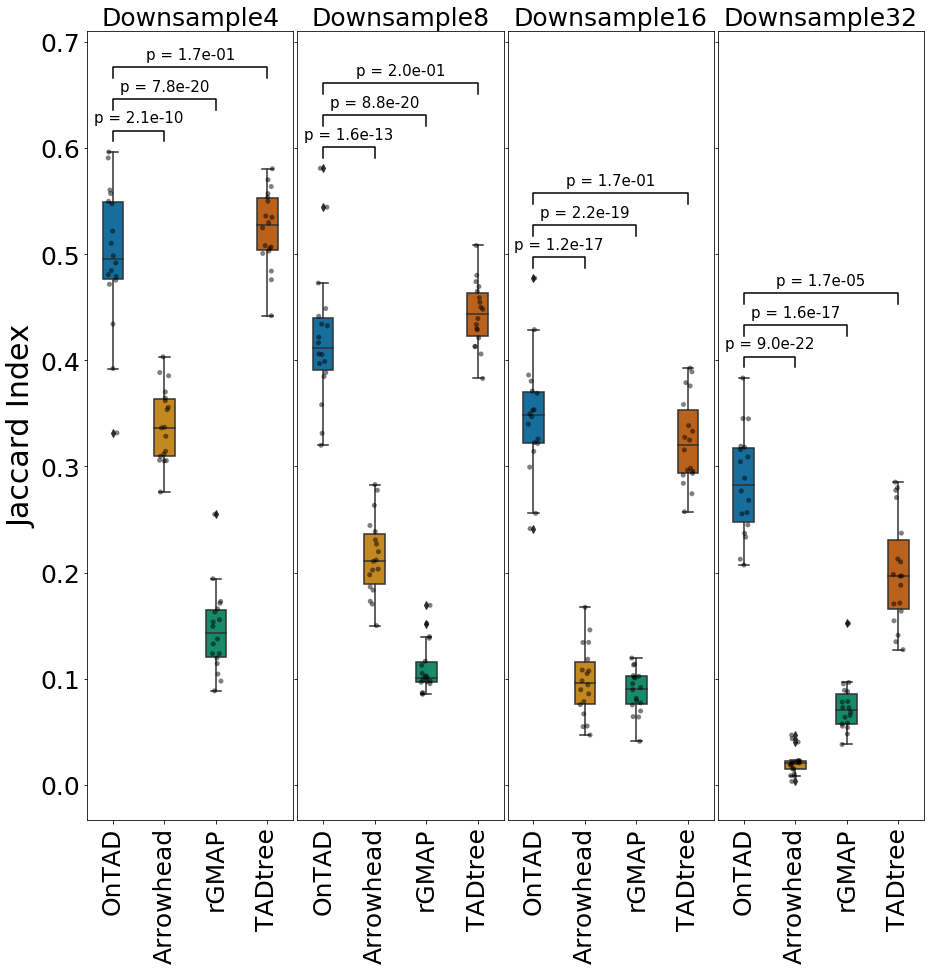

In [90]:
jartable4 = pandas.DataFrame({'OnTAD':OnTAD_jardownsample4, 'Arrowhead':Arrow_jardownsample4, 'rGMAP': rGMAP_jardownsample4, 'TADtree': TADtree_jardownsample4})
jartable8 = pandas.DataFrame({'OnTAD':OnTAD_jardownsample8, 'Arrowhead':Arrow_jardownsample8, 'rGMAP': rGMAP_jardownsample8, 'TADtree': TADtree_jardownsample8})
jartable16 = pandas.DataFrame({'OnTAD':OnTAD_jardownsample16, 'Arrowhead':Arrow_jardownsample16, 'rGMAP': rGMAP_jardownsample16, 'TADtree': TADtree_jardownsample16})
jartable32 = pandas.DataFrame({'OnTAD':OnTAD_jardownsample32, 'Arrowhead':Arrow_jardownsample32, 'rGMAP': rGMAP_jardownsample32, 'TADtree': TADtree_jardownsample32})
plt.figure(2,figsize=(15,15))
ax1 = plt.subplot(141)
sns.boxplot(data=jartable4, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=jartable4,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = jartable4.max()[1] + 0.01, 0.01, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample4, Arrow_jardownsample4)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 2   # columns 
ax1.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample4, rGMAP_jardownsample4)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 3   # columns 
ax1.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample4, TADtree_jardownsample4)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

plt.yticks(color='k',size=25)
plt.xticks(color='k',size=25)
plt.xticks(rotation=90)
plt.ylabel('Jaccard Index', {'color': 'k', 'fontsize': 30})
ax1.set_title('Downsample4', fontdict={'fontsize':25})

ax2 = plt.subplot(142, sharey=ax1)
sns.boxplot(data=jartable8, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=jartable8,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = jartable8.max()[1] + 0.01, 0.01, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample8, Arrow_jardownsample8)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 2   # columns 
ax2.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample8, rGMAP_jardownsample8)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 3   # columns 
ax2.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample8, TADtree_jardownsample8)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

plt.xticks(color='k',size=25)

plt.xticks(rotation=90)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_title('Downsample8', fontdict={'fontsize':25})

ax3 = plt.subplot(143, sharey=ax1)
sns.boxplot(data=jartable16, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=jartable16,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = jartable16.max()[1] + 0.01, 0.01, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample16, Arrow_jardownsample16)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 2   # columns 
ax3.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample16, rGMAP_jardownsample16)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 3   # columns 
ax3.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample16, TADtree_jardownsample16)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

plt.xticks(color='k',size=25)

plt.xticks(rotation=90)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_title('Downsample16', fontdict={'fontsize':25})

ax4 = plt.subplot(144, sharey=ax1)
sns.boxplot(data=jartable32, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=jartable32,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = jartable32.max()[1] + 0.01, 0.01, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample32, Arrow_jardownsample32)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 2   # columns 
ax4.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample32, rGMAP_jardownsample32)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 3   # columns 
ax4.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_jardownsample32, TADtree_jardownsample32)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

plt.xticks(color='k',size=25)
plt.xticks(rotation=90)
plt.setp(ax4.get_yticklabels(), visible=False)
ax4.set_title('Downsample32', fontdict={'fontsize':25})
plt.subplots_adjust(bottom=0.15, wspace=0.02)
plt.savefig("/Users/linan/Desktop/jar_downsample.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()

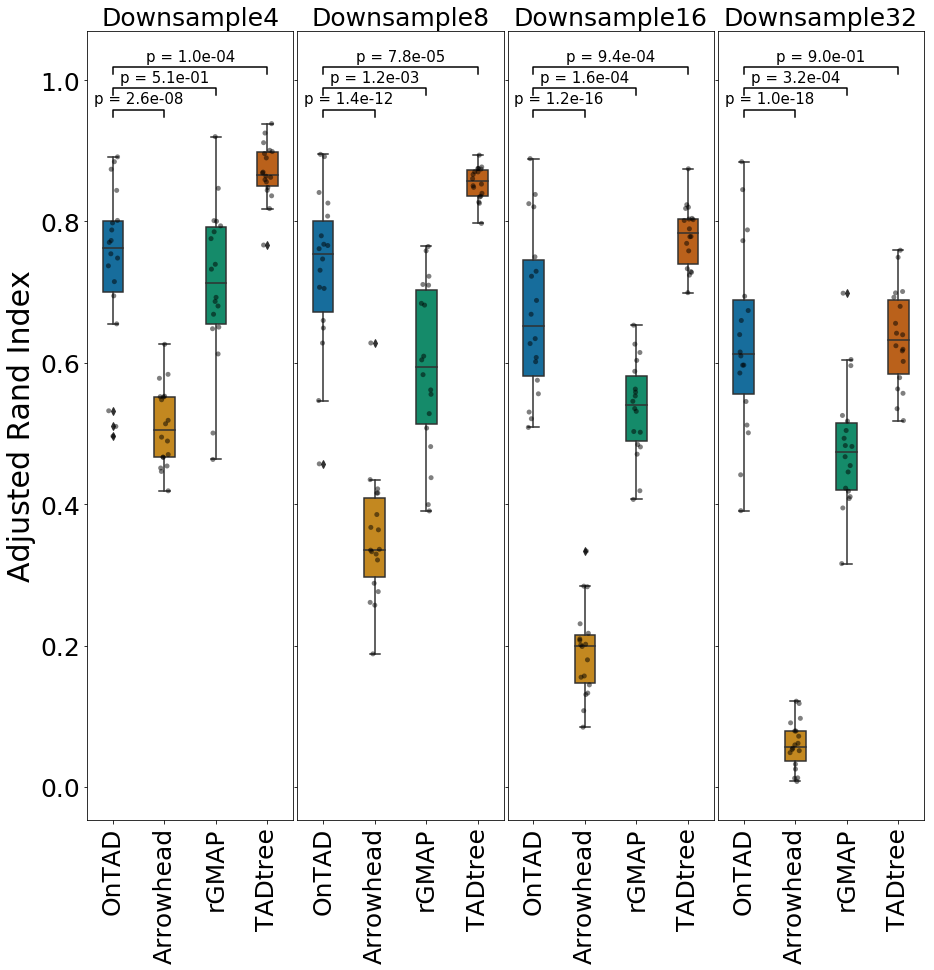

In [91]:
randtable4 = pandas.DataFrame({'OnTAD':OnTAD_randdownsample4, 'Arrowhead':Arrow_randdownsample4, 'rGMAP': rGMAP_randdownsample4, 'TADtree': TADtree_randdownsample4})
randtable8 = pandas.DataFrame({'OnTAD':OnTAD_randdownsample8, 'Arrowhead':Arrow_randdownsample8, 'rGMAP': rGMAP_randdownsample8, 'TADtree': TADtree_randdownsample8})
randtable16 = pandas.DataFrame({'OnTAD':OnTAD_randdownsample16, 'Arrowhead':Arrow_randdownsample16, 'rGMAP': rGMAP_randdownsample16, 'TADtree': TADtree_randdownsample16})
randtable32 = pandas.DataFrame({'OnTAD':OnTAD_randdownsample32, 'Arrowhead':Arrow_randdownsample32, 'rGMAP': rGMAP_randdownsample32, 'TADtree': TADtree_randdownsample32})
plt.figure(2,figsize=(15,15))
ax1 = plt.subplot(141)
sns.boxplot(data=randtable4, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=randtable4,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = max(randtable4.max()) + 0.01, 0.01, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample4, Arrow_randdownsample4)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 2   # columns 
ax1.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample4, rGMAP_randdownsample4)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 3   # columns 
ax1.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample4, TADtree_randdownsample4)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

plt.yticks(color='k',size=25)
plt.xticks(color='k',size=25)

plt.xticks(rotation=90)
plt.ylabel('Adjusted Rand Index', {'color': 'k', 'fontsize': 30})
ax1.set_title('Downsample4', fontdict={'fontsize':25})

ax2 = plt.subplot(142, sharey=ax1)
sns.boxplot(data=randtable8, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=randtable8,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = max(randtable4.max()) + 0.01, 0.01, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample8, Arrow_randdownsample8)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 2   # columns 
ax2.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample8, rGMAP_randdownsample8)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 3   # columns 
ax2.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample8, TADtree_randdownsample8)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

plt.xticks(color='k',size=25)
plt.xticks(rotation=90)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_title('Downsample8', fontdict={'fontsize':25})

ax3 = plt.subplot(143, sharey=ax1)
sns.boxplot(data=randtable16, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=randtable16,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = max(randtable4.max()) + 0.01, 0.01, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample16, Arrow_randdownsample16)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 2   # columns 
ax3.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample16, rGMAP_randdownsample16)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 3   # columns 
ax3.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample16, TADtree_randdownsample16)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

plt.xticks(color='k',size=25)
plt.xticks(rotation=90)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_title('Downsample16', fontdict={'fontsize':25})

ax4 = plt.subplot(144, sharey=ax1)
sns.boxplot(data=randtable32, width=0.4, palette="colorblind", order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])
sns.stripplot(data=randtable32,jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black',order=["OnTAD", 'Arrowhead', 'rGMAP', 'TADtree'])

# statistical annotation
x1, x2 = 0, 1   # columns 
y, h, col = max(randtable4.max()) + 0.01, 0.01, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+1.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample32, Arrow_randdownsample32)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 2   # columns 
ax4.plot([x1, x1, x2, x2], [y+3*h, y+4*h, y+4*h, y+3*h], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+4.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample32, rGMAP_randdownsample32)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

x1, x2 = 0, 3   # columns 
ax4.plot([x1, x1, x2, x2], [y+6*h, y+7*h, y+7*h, y+6*h], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+7.5*h, r"p = %1.1e"% (stats.ttest_ind(OnTAD_randdownsample32, TADtree_randdownsample32)[1]), ha='center', va='bottom', color=col, fontdict={'fontsize':15})

plt.xticks(color='k',size=25)
plt.xticks(rotation=90)
plt.setp(ax4.get_yticklabels(), visible=False)
ax4.set_title('Downsample32', fontdict={'fontsize':25})
plt.subplots_adjust(bottom=0.15, wspace=0.02)
plt.savefig("/Users/linan/Desktop/rand_downsample.png", transparent=True, dpi = 200, bbox_inches='tight')
plt.show()